In [2]:
import math
import numpy as np
import re
import random
import os

from collections import Counter
from matplotlib import pyplot as plt
from PIL import Image

In [3]:
os.listdir('train-letters/0')

['A_100.png', 'A_80.png', 'A_85.png', 'A_90.png', 'A_95.png']

In [4]:
## Split each image into four segments of 120px width
# Labelling scheme: A-Z are 0-25 and 0-9 are 26-35
def labelFromChar(ch):
  if (ch >= 'A' and ch <= 'Z'):
    return ord(ch) - ord('A')
  else:
    return 26 + ord(ch) - ord('0')

def charFromLabel(label):
  if (label >= 0 and label <= 25):
    return chr(label + ord('A'))
  else:
    return chr(label - 26 + ord('0'))

In [5]:
val = [0,0,0,0,0,0,1,1,1,1,1,2,2,2,2,2,3,3,3,3,3,4,4,4,4,4]
# Load images
img_folder = 'train-letters'
letter_set = []
letter_train_set = []
letter_val_set = []
for i in range(26):
    img_files = os.listdir(f'{img_folder}/{i}')
    letter = chr(ord('A') + i)
    j = 0
    for img_file in img_files:
        # print(img_file)
        img = np.array(Image.open(os.path.join(img_folder, str(i), img_file)))
        font_size_str = img_file[2:-4]
        letter_set.append((img, i))
        # Hardcoding for now: remove the images of font sizes 95 for testing and validation
        if (font_size_str == '95'):
            letter_val_set.append((img, i))
        else:
            letter_train_set.append((img, i))
print(f"Loaded {len(letter_set)} images from folder:\n{img_folder}")
print(f'{len(letter_train_set)} training, {len(letter_val_set)} validation')

Loaded 130 images from folder:
train-letters
104 training, 26 validation


In [6]:
all_dataset = letter_set
train_dataset = letter_train_set
val_dataset = letter_val_set
# Shuffle the dataset
np.random.shuffle(train_dataset)
X_dataset_all_orig = np.array([data[0] for data in all_dataset])
Y_dataset_all_orig = np.array([data[1] for data in all_dataset])
X_dataset_train_orig = np.array([data[0] for data in train_dataset])
Y_dataset_train_orig = np.array([data[1] for data in train_dataset])
X_dataset_val_orig = np.array([data[0] for data in val_dataset])
Y_dataset_val_orig = np.array([data[1] for data in val_dataset])
print(Y_dataset_train_orig)

[ 8  6  0  4  7 18 17  4 18 18  1 21 16  1 23  5 21 10 10  2  4  9 11  8
 18  6 11 20 14 22 22  4 20 14  6 13 15 20  7  2 14 11 25  3  8 19  9 11
 20 15 10 19  7 17 17  3 17 14 13  0 12 15  9  8  9 19 16 12  7 12 21 19
 15 16 13  0  5 24 25 23  0 16  5 21  2 24 22 10 23 25 24 23  1  3  5 22
  1 24  3 13  6 25  2 12]


In [7]:
type(Y_dataset_val_orig[0])

numpy.int32

In [8]:
NUMBER_OF_LABELS = 26
CONFIDENCE_THRESHOLD = 0.01

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

# Normalize X (images) dataset (8 bit value 0..255 converted to float 0..1)
X_dataset_all = X_dataset_all_orig/255.
X_dataset_train = X_dataset_train_orig/255.
X_dataset_val = X_dataset_val_orig/255.

# Convert Y dataset to one-hot encoding
Y_dataset_all = convert_to_one_hot(Y_dataset_all_orig, NUMBER_OF_LABELS).T
Y_dataset_train = convert_to_one_hot(Y_dataset_train_orig, NUMBER_OF_LABELS).T
Y_dataset_val = convert_to_one_hot(Y_dataset_val_orig, NUMBER_OF_LABELS).T

print(Y_dataset_train[0]) # Check if matches the first label in Y_dataset_orig
print(Y_dataset_train[-1]) # Check if matches the last label in Y_dataset_orig

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


None of this is our true test dataset. Model performance needs to be tested on actual SIFTed images, but that will come later.

In [9]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend

In [10]:
def reset_weights(model):
  for ix, layer in enumerate(model.layers):
      if (hasattr(model.layers[ix], 'kernel_initializer') and
          hasattr(model.layers[ix], 'bias_initializer')):
          weight_initializer = model.layers[ix].kernel_initializer
          bias_initializer = model.layers[ix].bias_initializer

          old_weights, old_biases = model.layers[ix].get_weights()

          model.layers[ix].set_weights([
              weight_initializer(shape=old_weights.shape),
              bias_initializer(shape=len(old_biases))])

In [11]:
LETTER_DIM_Y = 80
LETTER_DIM_X = 64
X_dataset_val[0].shape

(80, 64)

In [12]:
conv_model = models.Sequential()
conv_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                             input_shape=(LETTER_DIM_Y, LETTER_DIM_X, 1)))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
# Lines commented out to match the simpler lecture (Week 5) Keras code example
# conv_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# conv_model.add(layers.MaxPooling2D((2, 2)))
# conv_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Flatten())
conv_model.add(layers.Dropout(0.5))
conv_model.add(layers.Dense(64, activation='relu'))
conv_model.add(layers.Dense(NUMBER_OF_LABELS, activation='softmax'))
conv_model.summary()

c:\Users\alexa\ENPH353-clueboard-reader\.enph353env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 78, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 39, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 37, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16128)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16128)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,032,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │         1,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,052,762 (4.02 MB)

 Trainable params: 1,052,762 (4.02 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
LEARNING_RATE = 1e-4
conv_model.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.RMSprop(learning_rate=LEARNING_RATE),
                   metrics=['acc'])

In [14]:
reset_weights(conv_model)

In [15]:
history_conv = conv_model.fit(X_dataset_train, Y_dataset_train,
                              validation_data=(X_dataset_val, Y_dataset_val),
                              epochs=25,
                              batch_size=8)

# We can also run the training by specifiying the validation split directly.
#history_conv = conv_model.fit(X_dataset, Y_dataset,
#                              validation_split=VALIDATION_SPLIT,
#                              epochs=20,
#                              batch_size=16)

Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.0286 - loss: 3.2547 - val_acc: 0.2308 - val_loss: 3.0739
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.1687 - loss: 3.0976 - val_acc: 0.3462 - val_loss: 2.8689
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.3481 - loss: 2.9139 - val_acc: 0.5000 - val_loss: 2.6312
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.3973 - loss: 2.6436 - val_acc: 0.6538 - val_loss: 2.3236
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.4622 - loss: 2.4913 - val_acc: 0.7308 - val_loss: 2.0032
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.5785 - loss: 2.1463 - val_acc: 0.7308 - val_loss: 1.6456
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.6814 - loss: 1.7361 - val_acc: 0.9231 - val_loss: 1.2856
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.7762 - loss: 1.5032 - val_acc: 0.8846 - val_loss: 0.9712
Epoch 9/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.8580 - loss:

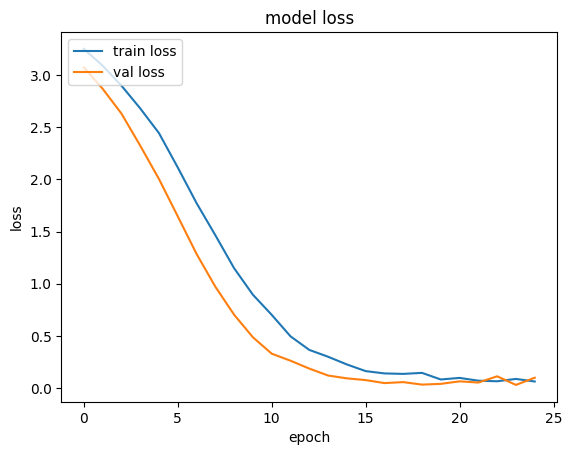

In [16]:
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

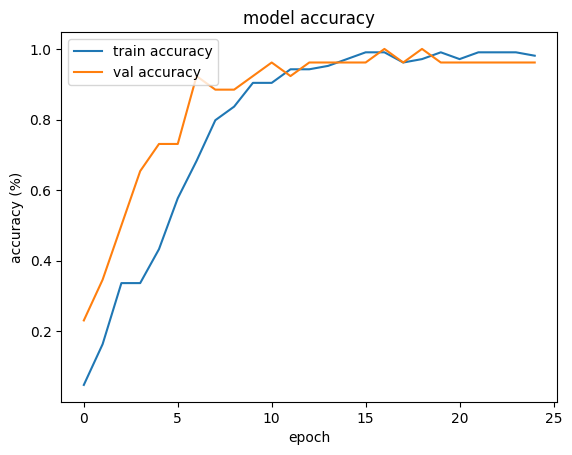

In [17]:
plt.plot(history_conv.history['acc'])
plt.plot(history_conv.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
plt.show()

### Validation loss

In [19]:
import sklearn.metrics
labels = [chr(ascii) for ascii in range(ord('A'), ord('Z') + 1)]
print(labels)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [20]:
true_y = np.argmax(Y_dataset_val, axis=1)
pred_y_prob = conv_model.predict(X_dataset_val, verbose=2)
pred_y = np.argmax(pred_y_prob, axis=1)
true_y_orig = [charFromLabel(label) for label in true_y]
pred_y_orig = [charFromLabel(label) for label in pred_y]
print(true_y_orig)
print(pred_y_orig)

1/1 - 0s - 85ms/step
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'Q', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


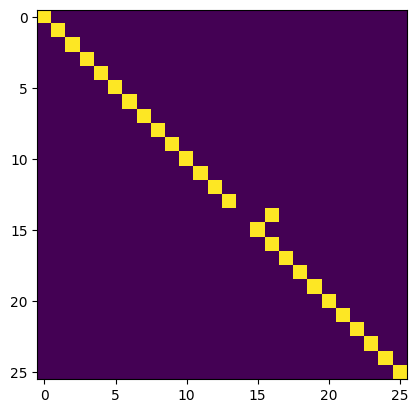

In [21]:
confusion_matrix = sklearn.metrics.confusion_matrix(true_y_orig, pred_y_orig, labels=labels)
plt.imshow(confusion_matrix)

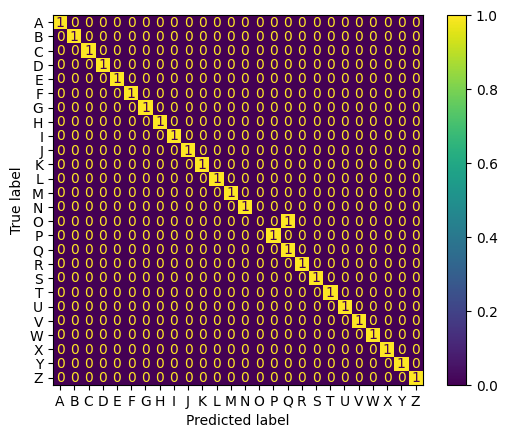

In [22]:
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)
disp.plot()
plt.show()

5/5 - 0s - 13ms/step


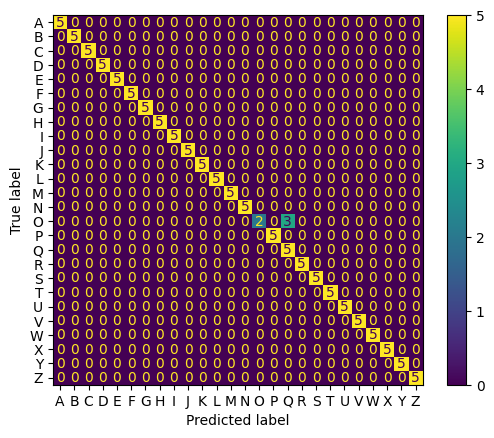

In [23]:
true_y = np.argmax(Y_dataset_all, axis=1)
pred_y_prob = conv_model.predict(X_dataset_all, verbose=2)
pred_y = np.argmax(pred_y_prob, axis=1)
confusion_matrix = sklearn.metrics.confusion_matrix(true_y, pred_y, labels=[i for i in range(NUMBER_OF_LABELS)])
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)
disp.plot()
plt.show()

Looks like Os are a particular challenge, being confused for Ds and Qs. Try adjusting the network architecture later to get this cleared up, or add more Os and Ds to the training dataset. (Perhaps aggressive downscaling and pooling leaves the corners of the D and mark of the Q less obvious. It may also be prudent to leave in the blurring in the original font, including when copying over solid images. Or taking outlines only may make the sharp corners easier to spot.)

But otherwise the network works (i.e. tends to identify the correct letter more often than not and doesn't throw any errors), and can be incorporated into a test program for the robot.

In [24]:
# Saving model parameters
conv_model.save('letter-recog-model.keras')  # The file needs to end with the .keras extension
conv_model.save('letter-recog-model.h5')  # The file needs to end with the .keras extension
# model = keras.models.load_model('path/to/location.keras')


In [25]:
# loaded_model = models.load_model('letter-recog-model.keras')
loaded_model = models.load_model('letter-recog-model.h5')
loaded_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 78, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 39, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 37, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16128)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16128)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,032,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │         1,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,052,764 (4.02 MB)

 Trainable params: 1,052,762 (4.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)